# Book Recommendation System

## Importing the libraries

In [1]:
!pip install scikit-surprise


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3163753 sha256=48a8c1b9c9798109b7e4356d5a1863c7af8d4b19ce9e3287052a77a6e189dfd8
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

## Importing the dataset

In [3]:
#To mount google drive, I put my dataset into my drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
#To change directory in google drive
import os
os.chdir('/content/drive/MyDrive/CS464-Project/dataset')

In [5]:
books_dataset = pd.read_csv('books_data.csv')
ratings_dataset = pd.read_csv('Books_rating.csv')

In [6]:
ratings_dataset.shape

(3000000, 10)

In [7]:
ratings_dataset.columns

Index(['Id', 'Title', 'Price', 'User_id', 'profileName', 'review/helpfulness',
       'review/score', 'review/time', 'review/summary', 'review/text'],
      dtype='object')

In [8]:
books_dataset.columns

Index(['Title', 'description', 'authors', 'image', 'previewLink', 'publisher',
       'publishedDate', 'infoLink', 'categories', 'ratingsCount'],
      dtype='object')

In [9]:
books_dataset.head(5)

,Title,description,authors,image,previewLink,publisher,publishedDate,infoLink,categories,ratingsCount
0,Its Only Art If Its Well Hung!,NaN,['Julie Strain'],http://books.google.com/books/content?id=DykPA...,http://books.google.nl/books?id=DykPAAAACAAJ&d...,NaN,1996,http://books.google.nl/books?id=DykPAAAACAAJ&d...,['Comics & Graphic Novels'],NaN
1,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,['Philip Nel'],http://books.google.com/books/content?id=IjvHQ...,http://books.google.nl/books?id=IjvHQsCn_pgC&p...,A&C Black,2005-01-01,http://books.google.nl/books?id=IjvHQsCn_pgC&d...,['Biography & Autobiography'],NaN
2,Wonderful Worship in Smaller Churches,This resource includes twelve principles in un...,['David R. Ray'],http://books.google.com/books/content?id=2tsDA...,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,NaN,2000,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,['Religion'],NaN
3,Whispers of the Wicked Saints,Julia Thomas finds her life spinning out of co...,['Veronica Haddon'],http://books.google.com/books/content?id=aRSIg...,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,iUniverse,2005-02,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,['Fiction'],NaN
4,"Nation Dance: Religion, Identity and Cultural ...",NaN,['Edward Long'],NaN,http://books.google.nl/books?id=399SPgAACAAJ&d...,NaN,2003-03-01,http://books.google.nl/books?id=399SPgAACAAJ&d...,NaN,NaN


In [10]:
ratings_dataset.head(5)

,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text
0,1882931173,Its Only Art If Its Well Hung!,NaN,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",7/7,4.0,940636800,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...
1,0826414346,Dr. Seuss: American Icon,NaN,A30TK6U7DNS82R,Kevin Killian,10/10,5.0,1095724800,Really Enjoyed It,I don't care much for Dr. Seuss but after read...
2,0826414346,Dr. Seuss: American Icon,NaN,A3UH4UZ4RSVO82,John Granger,10/11,5.0,1078790400,Essential for every personal and Public Library,"If people become the books they read and if ""t..."
3,0826414346,Dr. Seuss: American Icon,NaN,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",7/7,4.0,1090713600,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D..."
4,0826414346,Dr. Seuss: American Icon,NaN,A22X4XUPKF66MR,"D. H. Richards ""ninthwavestore""",3/3,4.0,1107993600,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...


## Data Pre-Processing


In [11]:
# Filter the dataset to include only users with at least 20 reviews
filtered_ratings_dataset = ratings_dataset.groupby('User_id').filter(lambda x: len(x) >= 20)

In [12]:
from sklearn.preprocessing import LabelEncoder

# Encoding for 'User_id', 'Title', and 'categories'
user_encoder = LabelEncoder()
title_encoder = LabelEncoder()

filtered_ratings_dataset['User_id'] = user_encoder.fit_transform(filtered_ratings_dataset['User_id'])
filtered_ratings_dataset['Title'] = title_encoder.fit_transform(filtered_ratings_dataset['Title'])

In [13]:
filtered_ratings_dataset.shape

(548134, 10)

In [14]:
selected_columns = ['Title', 'User_id', 'review/score', 'review/time']
filtered_ratings_dataset = filtered_ratings_dataset[selected_columns]

In [15]:
filtered_ratings_dataset.shape

(548134, 4)

In [16]:
filtered_ratings_dataset.head(5)

,Title,User_id,review/score,review/time
1,20778,5128,5.0,1095724800
3,20778,4136,4.0,1090713600
5,20778,3562,4.0,1127174400
6,20778,321,5.0,1100131200
11,93849,5561,5.0,1291766400


MATRIX FACTORIZATION

In [17]:
#preparing the dataset for matrix factorization
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(filtered_ratings_dataset[['User_id', 'Title', 'review/score']], reader)

In [18]:
#SVD for matrix factorization
model = SVD()

cross_validate(model, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

trainset = data.build_full_trainset()
model.fit(trainset)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.7411  0.7391  0.7432  0.7395  0.7393  0.7405  0.0015  
MAE (testset)     0.5061  0.5057  0.5094  0.5066  0.5059  0.5067  0.0014  
Fit time          12.54   13.73   13.41   13.76   14.16   13.52   0.54    
Test time         2.06    1.35    1.26    1.39    1.78    1.57    0.31    


## Split Data Into Training-Validation-Test Set

In [19]:
# Sort the dataset based on 'review/time'
filtered_ratings_dataset.sort_values('review/time', inplace=True)

# Calculate the indices for splitting
total_rows = len(filtered_ratings_dataset)
train_size = int(0.8 * total_rows)
test_size = int(0.1 * total_rows)

# Split the dataset
train_set = filtered_ratings_dataset.iloc[:train_size]
validation_set = filtered_ratings_dataset.iloc[train_size:(train_size + test_size)]
test_set = filtered_ratings_dataset.iloc[(train_size + test_size):]

## Train Model

In [20]:
# Import necessary libraries for Random Forest Regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Define the Random Forest model
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)  # You can adjust the number of estimators as needed

# Train the Random Forest model
random_forest_model.fit(
    train_set[['User_id', 'Title']],
    train_set['review/score']
)

# Predict on the validation set
validation_predictions_rf = random_forest_model.predict(
    validation_set[['User_id', 'Title']]
)

# Evaluate the model on the validation set
validation_loss_rf = mean_squared_error(validation_set['review/score'], validation_predictions_rf)
print(f'Validation Loss: {validation_loss_rf}')

Validation Loss: 1.2595893368712667


## Test Results

In [21]:
# Predict on the test set
test_predictions_rf = random_forest_model.predict(
    test_set[['User_id', 'Title']]
)

# Evaluate the model on the test set
test_loss_rf = mean_squared_error(test_set['review/score'], test_predictions_rf)
print(f'Test Loss (Random Forest): {test_loss_rf}')

# Make predictions on the test set
test_predictions_rf = random_forest_model.predict(
    test_set[['User_id', 'Title']]
)

# Create a DataFrame with user, item, and predicted score
predictions_df_rf = pd.DataFrame({
    'User_id': test_set['User_id'],
    'Title': test_set['Title'],
    'Actual_Score': test_set['review/score'],
    'Predicted_Score': test_predictions_rf,
})


Test Loss (Random Forest): 1.2320484649392724


In [22]:
from sklearn.metrics import accuracy_score

# Define a threshold for classification
threshold_rf = 3

# Convert the continuous predictions to binary (1 if predicted score >= threshold, 0 otherwise)
binary_predictions_rf = (test_predictions_rf >= threshold_rf).astype(int)

# Evaluate accuracy based on the threshold
accuracy_binary_rf = accuracy_score((test_set['review/score'] >= threshold_rf).astype(int), binary_predictions_rf)
print(f'Accuracy (Threshold={threshold_rf}) - Random Forest: {accuracy_binary_rf}')

Accuracy (Threshold=3) - Random Forest: 0.9069580764038384


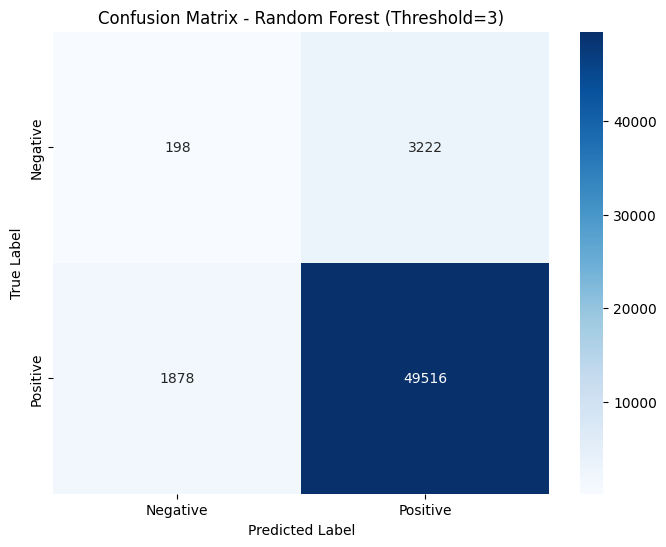

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the confusion matrix
cm_rf = confusion_matrix((test_set['review/score'] >= threshold_rf).astype(int), binary_predictions_rf)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix - Random Forest (Threshold={threshold_rf})')
plt.show()

DISPLAYING THE RESULTS BY NOT USING MATRIX FACTORIZATION


In [34]:
# Rastgele bir kodlanmış kullanıcı ID'si seçme
user_id_encoded = np.random.choice(test_set['User_id'].unique())

# Veri setinden rastgele 10 kitap başlığını seçme ve kodlama
random_book_titles = np.random.choice(test_set['Title'].unique(), size=10, replace=False)

# Kullanıcı ID'sini ve kitap başlıklarını uygun formata dönüştürme
user_ids_formatted = np.array([user_id_encoded] * 10, dtype='int32')
book_titles_formatted = np.array(random_book_titles, dtype='int32')

# Model tahminlerini yapma
predicted_scores_rf = random_forest_model.predict(np.column_stack((user_ids_formatted, book_titles_formatted)))

# Tahmin edilen puanları ve kitap başlıklarını bir DataFrame'e dönüştürme
recommendations_df_rf = pd.DataFrame({
    'Book_Title': title_encoder.inverse_transform(random_book_titles),
    'Predicted_Score': predicted_scores_rf
})

# Puanı 3.0'dan yüksek olan kitapları filtreleme ve azalan sırada sıralama
recommended_books_rf = recommendations_df_rf[recommendations_df_rf['Predicted_Score'] > 3.0].sort_values(by='Predicted_Score', ascending=False)

# Önerilen kitapları ve tahmin edilen puanları kullanıcıya sunma
print(f"Recommended Books for User ID (encoded) - Random Forest: {user_id_encoded}")
print(recommended_books_rf)

Recommended Books for User ID (encoded) - Random Forest: 2120
                                          Book_Title  Predicted_Score
1                                   Lament for a son         4.550000
9  AUSTERE ACADEMY (SERIES OF UNFORTUNATE EVENTS,...         4.530000
5                        An alarm to the unconverted         4.290000
6                                          Cape Cod,         4.090000
0  Are You Being Served?: The Inside Story of Bri...         4.040000
7  Imagine Nation: The American Counterculture of...         3.740000
2  Passionate Patchwork: Over 20 Original Quilt D...         3.710000
4                                     Charlotte Gray         3.650000
8         The Postcard (Amish Country Crossroads #1)         3.570000
3    The Poems of Emily Dickinson: Centenary Edition         3.208333


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


DISPLAYING THE RESULTS BY USING MATRIX FACTORIZATION


In [35]:
#Everytime you run the following code, a random user is selected and the recommended books with its ratings are shown
#a specific but a random user is selected here
user_id_encoded = np.random.choice(filtered_ratings_dataset['User_id'].unique())
book_titles = np.random.choice(filtered_ratings_dataset['Title'].unique(), size=10, replace=False)

#predicting the ratings of the books for the selected user
predicted_ratings = [model.predict(user_id_encoded, bt).est for bt in book_titles]

#DataFrame creation for the recommendation
recommendations_df = pd.DataFrame({
    'Book_Title': title_encoder.inverse_transform(book_titles),
    'Predicted_Score': predicted_ratings
})
recommended_books = recommendations_df[recommendations_df['Predicted_Score'] > 3.0].sort_values(by='Predicted_Score', ascending=False)

print(f"Recommended Books for User ID {user_id_encoded}:")
print(recommended_books)

Recommended Books for User ID 2713:
                                          Book_Title  Predicted_Score
6                                     Figure drawing         4.792972
5                                       The Reverend         4.693525
7            Crime and Punishment (Penguin Classics)         4.633979
3         BGP4: Inter-Domain Routing in the Internet         4.581652
2  The Cambridge Companion to Postmodern Theology...         4.527633
9                           Professional VB.NET 2003         4.433423
4                                    Girlz Night Out         4.385297
0                    The London Pigeon Wars: A Novel         4.375992
8                           August is a Wicked Month         4.310577
1                                      Port Eternity         4.248208
